In [1]:
dataset_name = "exchange-3_cpm_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1H', data))
# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1H", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-08-19 18:15:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:15:01
End date:  2011-09-07 14:15:01
Missing time stamps: 
 DatetimeIndex(['2011-07-07 03:15:01', '2011-07-07 04:15:01',
               '2011-07-08 03:15:01', '2011-07-08 04:15:01',
               '2011-07-08 05:15:01', '2011-07-08 07:15:01',
               '2011-07-08 08:15:01', '2011-07-08 11:15:01',
               '2011-07-08 12:15:01', '2011-07-08 13:15:01',
               ...
               '2011-09-01 14:15:01', '2011-09-01 15:15:01',
               '2011-09-01 16:15:01', '2011-09-01 17:15:01',
               '2011-09-04 18:15:01', '2011-09-04 20:15:01',
               '2011-09-05 14:15:01', '2011-09-05 16:15:01',
               '2011-09-06 00:15:01', '2011-09-06 13:15:01'],
              dtype='datetime64[ns]', length=109, freq=None)
Fill Missing Time Steps with Interpolation
Length:  1647
Time step size:  1H
Start Date:  2011-07-01 00:15:01
End Date:  2011-09-07 14:15:01
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [1194]


# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

 50%|█████     | 825/1647 [00:00<00:00, 8228.29it/s]

Initial Mean 0.8388571332496416
Initial StdDev 0.40610042120107126


 61%|██████    | 997/1647 [00:00<00:00, 9967.78it/s]

eta:  0.5
lambda:  0.99
MSE:  0.06623000111011047
Initial Mean 0.8388571332496416
Initial StdDev 0.40610042120107126


 47%|████▋     | 770/1647 [00:00<00:00, 6787.11it/s]

eta:  0.5
lambda:  0.999
MSE:  0.09368353298316769
Initial Mean 0.8388571332496416
Initial StdDev 0.40610042120107126


100%|██████████| 1647/1647 [00:00<00:00, 10108.31it/s]

eta:  0.5
lambda:  0.9999
MSE:  0.09894015098873729
Initial Mean 0.8388571332496416
Initial StdDev 0.40610042120107126



100%|██████████| 1647/1647 [00:00<00:00, 9681.31it/s]

eta:  1
lambda:  0.99
MSE:  0.06228786885674584
Initial Mean 0.8388571332496416
Initial StdDev 0.40610042120107126



100%|██████████| 1647/1647 [00:00<00:00, 10803.40it/s]

eta:  1
lambda:  0.999
MSE:  0.08370795630812222
Initial Mean 0.8388571332496416
Initial StdDev 0.40610042120107126


eta:  1
lambda:  0.9999
MSE:  0.09010822474532704

best params:  eta 1 lambda 0.99


 48%|████▊     | 789/1647 [00:00<00:00, 7887.56it/s]

Initial Mean 0.8388571332496416
Initial StdDev 0.40610042120107126


100%|██████████| 1647/1647 [00:00<00:00, 9575.60it/s]


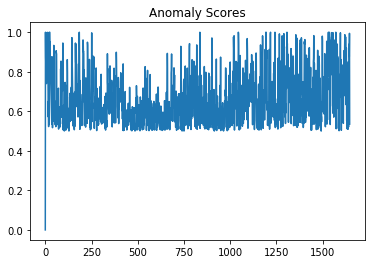

Time:  0.5830225944519043


['anomaly_scores/GLM/exchange-3_cpm_results']

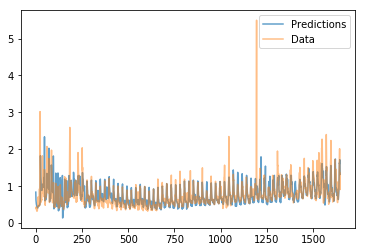

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=1, lambda_=0.99,plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Anomalous

In [6]:
# only need one window size

# save_path = "anomaly_scores/anomalous/" + dataset_name
# output_dict = ad.anomalous(ts_length=100,
#                            upper=(.2/100) * ad.get_length(),
#                            plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 22.77648
 ARIMA(0,0,0) with non-zero mean : 189.7061
 ARIMA(1,0,0) with non-zero mean : 42.46409
 ARIMA(0,0,1) with non-zero mean : 57.9824
 ARIMA(0,0,0) with zero mean     : 187.6187
 ARIMA(1,0,2) with non-zero mean : 23.62524
 ARIMA(2,0,1) with non-zero mean : 24.76037
 ARIMA(3,0,2) with non-zero mean : 26.06509
 ARIMA(2,0,3) with non-zero mean : 25.07671
 ARIMA(1,0,1) with non-zero mean : 21.57415
 ARIMA(0,0,2) with non-zero mean : 31.68155
 ARIMA(2,0,0) with non-zero mean : 24.85795
 ARIMA(1,0,1) with zero mean     : 19.51041
 ARIMA(0,0,1) with zero mean     : 56.03212
 ARIMA(1,0,0) with zero mean     : 40.74827
 ARIMA(2,0,1) with zero mean     : 22.67239
 ARIMA(1,0,2) with zero mean     : 21.52406
 ARIMA(0,0,2) with zero mean     : 30.05903
 ARIMA(2,0,0) with zero mean     : 22.87517
 ARIMA(2,0,2) with zero mean     : 20.77952

 Now re-fitting the best model(s) without approximations...

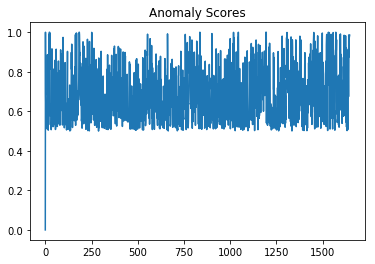

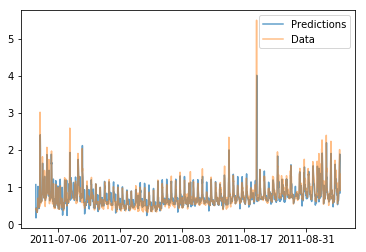

Time:  18.839401960372925


['anomaly_scores/SARIMA_auto/exchange-3_cpm_results']

In [7]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [8]:
# optimization step

step_sizes = [100, 200]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09498921376789998


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08355254833061826


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07896450867160834


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07622518898778308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07594397441030774


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09784874574572078


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08691864393768092


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.08279038872100582


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08141025945714336


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.07996914489471757


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09643834433489602


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08393121593528366


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07747817154407491


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07648390883664981


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07573333425149659


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09773963681562815


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08650421866711629


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0828908178021186


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08167619278340883


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.08035641633812535


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09534632038939633


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08358223897089868


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07715768049425055


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0766566358440729


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07610987053990943


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09782153080833447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08707625922831551


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.08335408901679713


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0816630173886188


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0809399680223215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09513410470318252


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08342699851481729


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0791716332172511


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07647797159515368


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07623329978722994


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09779029347910924


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08683774701294832


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.08269292331016179


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08137563032277795


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.08079792274184314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09493288799054288


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08368397504068789


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07773634714685924


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07648190163781023


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07584976934311632


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09774725997506986


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08716106579494604


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.082566799609668


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08143611289530395


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.08093789107999054


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09498921376789998


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08355254833061826


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07896450867160834


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07622518898778308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07594397441030774


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09784874574572078


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08691864393768092


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.08279038872100582


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08141025945714336


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.07996914489471757


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09643834433489602


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08393121593528366


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07747817154407491


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07648390883664981


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07573333425149659


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09773963681562815


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08650421866711629


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0828908178021186


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08167619278340883


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.08035641633812535


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09534632038939633


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08358223897089868


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07715768049425055


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0766566358440729


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07610987053990943


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09782153080833447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08707625922831551


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.08335408901679713


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0816630173886188


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0809399680223215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09513410470318252


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08342699851481729


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0791716332172511


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07647797159515368


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07623329978722994


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09779029347910924


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08683774701294832


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.08269292331016179


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08137563032277795


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.08079792274184314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.09493288799054288


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.08368397504068789


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.07773634714685924


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.07648190163781023


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.07584976934311632


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.09774725997506986


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.08716106579494604


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.082566799609668


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.08143611289530395
Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.08093789107999054

best params:  Step Size 100 Seasonality Prior Scale 5 Seasonality Mode additive Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


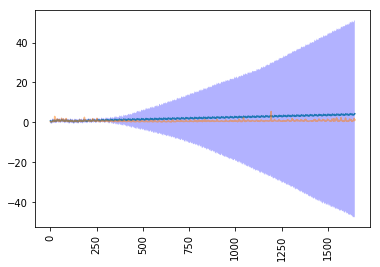

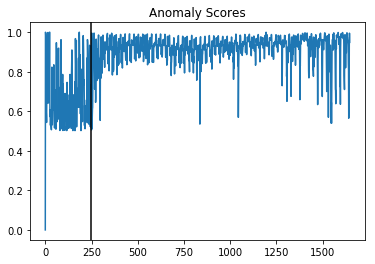

Time:  17.266072273254395


['anomaly_scores/Prophet/exchange-3_cpm_results']

In [9]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=5,
                                  seasonality_mode="additive",
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [10]:
# only need one window size

# save_path = "anomaly_scores/Twitter/" + dataset_name
# output_dict = ad.twitterad(period=24,max_anoms=((.2/100) * ad.get_length())/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# HTM

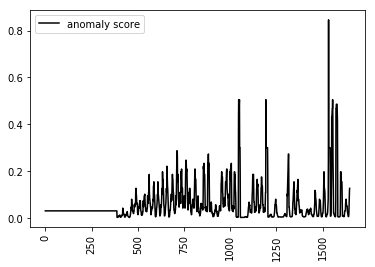

Time:  17.49


['anomaly_scores/HTM/exchange-3_cpm_results']

In [11]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "17.49")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "17.49"}
joblib.dump(output_dict, save_path)

# STL Resid

In [12]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.3220044781193288
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.3275725988617957
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.319551990186725
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.3220044781193288
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.318212289397126
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.3205684204059236
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer: 

R stlplus completed: 247 no missing True
STL Resid Sum:  2.7295705649252593
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  9.429061900315372
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  9.440714002625036
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  9.423156969038404
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  9.429061900315372
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  9.420123453911
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  9.4255076218739

R stlplus completed: 247 no missing True
STL Resid Sum:  1.2902113050242734
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.2907593814682812
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.196434782001265
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.206131070758941
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.191875629021416
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.196434782001265
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.18945343389452


R stlplus completed: 247 no missing True
STL Resid Sum:  0.0007047582024783314
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0005143777239673524
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0006514043321593771
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.747743411942885
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.755632384340798
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.7444097618252385
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.7477

R stlplus completed: 247 no missing True
STL Resid Sum:  4.768382120364872
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.770639596553749
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.7675893199638875
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.7691264430804505
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.5367828126580214
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.564337918235833
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.514627089693832
swindow:  5
sdeg

R stlplus completed: 247 no missing True
STL Resid Sum:  1.507647966163351
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.504620101656275
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.990670461659927
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.952919989603387
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.977671064126559
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.990670461659927
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.97448596944548
swindow:  5
sdegree:  0
twindow:  11
td

R stlplus completed: 247 no missing True
STL Resid Sum:  3.242044460533952
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.3425513203742776
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.1832568868884565
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.242044460533952
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.158213828943111
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.205771480940641
swindow:  5
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.0662157993133756
swindow:  5
sdegree:  1
twindow:  9
tdeg

R stlplus completed: 247 no missing True
STL Resid Sum:  0.6475497350482705
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6547546284056204
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6397213378502143
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.653362404340748
swindow:  5
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6355000832367319
swindow:  5
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6359689062018052
swindow:  5
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6283812527043158
swindow:  5
sdegree:  2
twindow:  7
t

R stlplus completed: 247 no missing True
STL Resid Sum:  1.7869650637041852
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.7963230965117316
swindow:  7
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.6262161083103028
swindow:  7
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.6070066270863104
swindow:  7
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.642362912689424
swindow:  7
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.6262161083103028
swindow:  7
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.648654619860063
swindow:  7
sdegree:  0
twindow:  5
td

R stlplus completed: 247 no missing True
STL Resid Sum:  5.696848156107814
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.644890484011919
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.7167474592296665
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.696848156107814
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.722085888128233
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.710247118417702
swindow:  7
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.070831289835078
swindow:  7
sdegree:  0
twindow:  11

R stlplus completed: 247 no missing True
STL Resid Sum:  4.034168558342632
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.114788979996925
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.0053388570173425
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.061839796184891
swindow:  7
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.762483104291955
swindow:  7
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.011881024576984
swindow:  7
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.686029350442751
swindow:  7
sdegree:  1
twindow:  9
tdegre

R stlplus completed: 247 no missing True
STL Resid Sum:  1.9362188364305253
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.985475168088111
swindow:  7
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6950287587035138
swindow:  7
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.875822839906535
swindow:  7
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6458074964863707
swindow:  7
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.6950287587035138
swindow:  7
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.626595252018088
swindow:  7
sdegree:  2
twindow:  7
tde

R stlplus completed: 247 no missing True
STL Resid Sum:  0.0013215338548281095
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0022407455790899445
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0007000306051911046
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0013215338548281095
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0005201460647573828
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0009033961126351091
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.648735967874171
swindow:  9
sdegree

R stlplus completed: 247 no missing True
STL Resid Sum:  3.4669482880840397
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.4484212438606523
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.472485206175951
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.4610472436594844
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.9682706506794103
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.1016447508245792
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.8956995868968214
swindow:  9
sdegree:  1
twindow:  

R stlplus completed: 247 no missing True
STL Resid Sum:  1.8041282359147888
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.8423902065774667
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  6.137133929953762
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  6.264718368021855
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  6.066222203302669
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  6.137133929953762
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  6.038808807252586
swindow:  9
sdegree:  1
twindow:  11

R stlplus completed: 247 no missing True
STL Resid Sum:  3.7792093099687567
swindow:  9
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.938589939048848
swindow:  9
sdegree:  2
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.6926961677711883
swindow:  9
sdegree:  2
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.7792093099687567
swindow:  9
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.6580132811987185
swindow:  9
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.7239001698821825
swindow:  9
sdegree:  2
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.6028080957119024
swindow:  9
sdegree:  2
twindow:  9
t

R stlplus completed: 247 no missing True
STL Resid Sum:  3.90851554452552
swindow:  11
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.8937663373296045
swindow:  11
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.909385963551738
swindow:  11
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.905732032484106
swindow:  11
sdegree:  0
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.772323552849475
swindow:  11
sdegree:  0
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.662230981940302
swindow:  11
sdegree:  0
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.8002839479836026
swindow:  11
sdegree:  0
twindow:  7

R stlplus completed: 247 no missing True
STL Resid Sum:  1.917099039438846
swindow:  11
sdegree:  1
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.9639143280518772
swindow:  11
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.6786118405785553
swindow:  11
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.8133725436360042
swindow:  11
sdegree:  1
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.6445432100277482
swindow:  11
sdegree:  1
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.6786118405785553
swindow:  11
sdegree:  1
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.63342851267092
swindow:  11
sdegree:  1
twindow:

R stlplus completed: 247 no missing True
STL Resid Sum:  5.830795514791958
swindow:  11
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.959711072620859
swindow:  11
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.776075225263573
swindow:  11
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.830795514791958
swindow:  11
sdegree:  1
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.7584192124536795
swindow:  11
sdegree:  1
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.794351095310716
swindow:  11
sdegree:  1
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.0785501372333854
swindow:  11
sdegree:  1
twin

R stlplus completed: 247 no missing True
STL Resid Sum:  4.222892204830073
swindow:  11
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.8316606450179065
swindow:  11
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.9401170939731665
swindow:  11
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.7924289470329904
swindow:  11
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.8686969938758455
swindow:  11
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  1.769680250797731
swindow:  11
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  2.0796373465585893
swindow:  11
sdegree:  2
twindow

In [13]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=5, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

1647
R stlplus completed: 1647 no missing True
Time:  1.3909828662872314


['anomaly_scores/stl/exchange-3_cpm_results']

# windowed gaussian

In [14]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  0.1683490951659194
Step size:  200
MSE:  0.1683490951659194
Step size:  300
MSE:  0.1683490951659194
Step size:  400
MSE:  0.1683490951659194
Step size:  500
MSE:  0.1683490951659194

best step size:  100


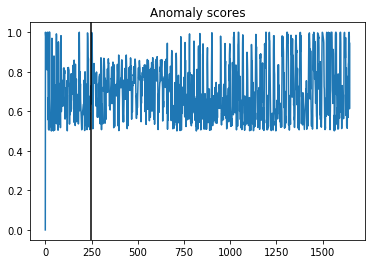

Time:  0.12105727195739746


['anomaly_scores/windowed_gaussian/exchange-3_cpm_results']

In [15]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

In [16]:
# only need one window size

# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)